In [2]:
import numpy as np
from numpy import linalg as linalg

import matplotlib
from matplotlib import colors, ticker, gridspec, rc
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sparse_pca as spca

import myfun as mf
import re
from importlib import reload

import os
matplotlib.use('Tkagg')

import matplotlib.pyplot as plt


In [3]:
# for mpl to use Latex
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin' # for matplotlib to find latex
matplotlib.use('ps')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')

In [4]:
###rna seq expression import### 
datdir  = '/Users/simonfreedman/cqub/xenopus/data'
plotdir = '/Users/simonfreedman/cqub/xenopus/plots'

#######################################################
############## NO NOGGIN DATA #########################
#######################################################
datfile = 'transcriptome_no_noggin.csv'
dat     = np.genfromtxt('{0}/{1}'.format(datdir,datfile),names=True,dtype=None,delimiter=',',encoding=None)

#### rna seq expression partitioning ####
geneInfo= np.array([list(row)[:3] for row in dat])
dats    = np.array([list(row)[3:] for row in dat])
gdats   = np.array([dats[:,i::3] for i in [0,1,2]])

# #######################################################
# ############## NOGGIN DATA ############################
# #######################################################
# datfile = 'transcriptome_noggin.csv'
# dat     = np.genfromtxt('{0}/{1}'.format(datdir,datfile),names=True,dtype=None,delimiter=',',encoding=None)

# #### rna seq expression partitioning ####
# geneInfo= np.array([list(row)[:1] for row in dat])
# dats    = np.array([list(row)[1:] for row in dat])
# gdats   = np.array([dats[:,i::4] for i in [0,1,2]])


stages  = [9,10,11,11.5,12,13]
ngenes  = gdats.shape[1] #1000
nreps   = gdats.shape[0]
nstages = gdats.shape[2]

In [6]:
# sum gene expression for genes with identical names
geneIdxDict = {}
for gnm,i in zip(geneInfo[:,1], range(geneInfo.shape[0])):
    geneIdxDict[gnm] = geneIdxDict.get(gnm, [])
    geneIdxDict[gnm].append(i)

gdatsS    = []
geneInfoS = []
for gnm, idxs in geneIdxDict.items():
    gdatsS.append(gdats[:,idxs,:].sum(axis=1))
    geneInfoS.append(geneInfo[idxs[0]])
gdatsS    = np.array(gdatsS).transpose((1,0,2))
geneInfoS = np.array(geneInfoS)

In [7]:
###### 
# FILTER OUT genes that are nearly 0 at all time points (for any one of the replicates)
thresh = 0.5

undetected = np.unique(np.hstack([np.where(np.sum(gdatsS[i], axis=1) <= thresh*nstages)[0] 
                                  for i in range(nreps)]))
# note: this 0.5 threshold was chosen based on a conversation with Carole; also:
# plot of distribution of tpm, which showed that below ~1 the data wasn't well sampled, AND 
# for rep 1, there's a gene which has constant low value of expression, and therefore 0 variance ==> nan z-score

gdatsNZ = np.delete(gdatsS,undetected,axis=1)
gdatsNZ[np.where(gdatsNZ==0)] = 0.005
lgdats  = np.log10(gdatsNZ)

ngenes     = lgdats.shape[1] #1000
geneInfoNZ = np.delete(geneInfoS, undetected, axis=0)
gene2idx   = {geneInfoNZ[i,1].lower():i for i in range(len(geneInfoNZ))}

In [8]:
# Raw data sorted
ysorting     = mf.argmaxsort(gdatsNZ[1].T)[0]
gdatsNZrs    = gdatsNZ.transpose((1,0,2)).reshape((-1,18))[ysorting]

In [9]:
#############################################CENTERING#########################################
# data needs to be centered across samples for proper SVD-ing [although maybe not in sklearn] #

##### Union of all reps ####
lgdatsf  = lgdats.transpose(1,0,2).reshape(lgdats.shape[1],lgdats.shape[0]*lgdats.shape[2])
mus      = lgdatsf.mean(axis=1)
sigs     = lgdatsf.std(axis=1,ddof=1)
lgdatsfz = (lgdatsf.T-mus)/sigs

##### Union of all reps ####
gdatsf  = gdatsNZ.transpose(1,0,2).reshape(gdatsNZ.shape[1],gdatsNZ.shape[0]*gdatsNZ.shape[2])
mus     = gdatsf.mean(axis=1)
sigs    = gdatsf.std(axis=1,ddof=1)
lgdatsfz = (gdatsf.T-mus)/sigs

In [11]:
lgdatsf.shape

(22341, 18)

In [12]:
mus.shape

(22341,)

In [10]:
# PCA
gpca    = linalg.svd(lgdatsfz, full_matrices = False)
eigs    = gpca[1]**2/ngenes
fPCs    = lgdatsfz.dot(gpca[2].T)

In [16]:
# Null distribution of eignevalues to figure out when they're significant
SVs = []
npermutes = 100

nrows = lgdatsfz.shape[0]
ncols = lgdatsfz.shape[1]

for i in range(npermutes):
    permuted = np.array([lgdatsfz[np.random.permutation(nrows),i] for i in range(ncols)]).T
    SVs.append(linalg.svd(permuted, full_matrices=False)[1])

In [17]:
ncols

22341

In [18]:
# histogram
eigsAll = np.array(SVs)**2/ncols
binmin  = 0.01
binmax  = 7
width   = 0.005
bins    = np.arange(binmin,binmax,width)
bcs     = np.histogram(eigsAll,bins,density=True)
bincenters = 0.5*(bcs[1][1:]+bcs[1][0:-1])
pdata      = 1/(width)

# marchenko pastur distribution
softThresh = lambda x: max(x,0)
mpdist     = np.vectorize(lambda lam, g: np.sqrt(softThresh((1+np.sqrt(g))**2-lam)*softThresh(lam-(1-np.sqrt(g))**2))/(2*np.pi*g*lam))

In [20]:
# AIC minimization to find optimal lambda for sparse PCA
# requires a measure of common variance (tibrishani book) which in the past has used PCA (Guo...Zu, J. Comp Graph Stat 2010)

# PCA common variances
nsig     = 3
sigSqPca = np.zeros(nsig)
xc       = np.copy(lgdatsfz)
xadjs    = []

for i in range(nsig):
    
    xadjs.append(np.copy(xc))
    
    xsvd      = linalg.svd(xc,full_matrices=False)
    xpcVecs   = xsvd[2].T
    pc1vec    = xpcVecs[:,[0]]
    
    pc1         = xc.dot(pc1vec).dot(pc1vec.T)
    sigSqPca[i] = np.linalg.norm(xc - pc1)**2
    
    xc -= pc1
    

In [21]:
x     = np.copy(lgdatsfz)
neigs = x.shape[0]
binit = np.ones_like(x.T)

niter = 100
pfreq = 1000

lams     = np.arange(100,5000,100)
stopCalc = [False, False, False]
zeroVec  = np.zeros((x.shape[1],1))

evecs     = []
errSpcaVH = np.zeros((nsig, len(lams)))
dfs       = np.zeros((nsig, len(lams)))

for i in range(nsig):
    
    xc        = xadjs[i]
    xsvd      = linalg.svd(xc,full_matrices=False)
    xpcVecs   = xsvd[2].T
    
    evecs.append([])

    for j in range(len(lams)):
                     
        # default initialization for lambda > lambda0
        evec1 = zeroVec
        df = 0
        
        lamsin = lams[j]*np.ones(neigs)
        #lamsin = np.hstack([[lams[j]],1200*np.ones(neigs-1)])
        
        if not stopCalc[i]:
            anew,bnew = spca.minimizeAB(xc, xpcVecs, binit, lamsin, niter, pfreq)

            bnewNorm  = np.linalg.norm(bnew, axis=0)
            vhat      = np.divide(bnew, bnewNorm, out=np.zeros_like(bnew), where=bnewNorm!=0) # normalize by nonzero entries
    
            evec1      = vhat[:,[0]]
            df         = np.where(evec1 != 0)[0].shape[0]
        
        evecs[i].append(evec1)    
        #spc1            = xc.dot(evec1).dot(evec1.T)
        spc1            = xc.dot(evec1).dot((anew[:,[0]]).T)

        errSpcaVH[i,j]  = np.linalg.norm(xc - spc1)**2                       
        dfs[i,j]   = df
            
        if df == 0:
            stopCalc[i] = True

iter 0, errors = [2.392e+07,4.331e+06,1.783e+06,2.681e+06,1.995e+06,1.767e+06,2.129e+06,2.249e+06,2.107e+06,2.264e+06,2.133e+06,2.299e+06,2.361e+06,2.271e+06,2.307e+06,2.292e+06,2.342e+06,2.256e+06] ==> total error = 6.349033e+07
iter 99, errors = [-3.162e+10,-2.793e+09,-7.954e+08,-3.285e+08,-1.604e+08,-2.709e+07,-2.028e+07,-1.025e+07,-7.126e+06,-3.252e+06,-3.104e+06,-1.723e+06,-1.257e+06,-1.138e+06,-1.034e+06,-1.052e+06,-4.622e+05,0.000e+00] ==> total error = -3.577798e+10
iter 0, errors = [-2.922e+10,-2.113e+09,-5.075e+08,-1.566e+08,-6.018e+06,1.734e+07,2.600e+07,1.042e+07,9.145e+06,4.675e+06,3.847e+06,3.689e+06,2.887e+06,2.556e+06,2.448e+06,2.551e+06,9.817e+05,0.000e+00] ==> total error = -3.191915e+10
iter 99, errors = [-2.925e+10,-2.217e+09,-5.554e+08,-1.984e+08,-7.641e+07,-7.170e+06,-5.042e+06,-1.428e+06,-1.607e+06,-3.278e+05,-4.947e+05,-1.662e+05,-7.893e+04,-1.115e+05,-8.704e+04,-1.233e+05,-1.915e+04,0.000e+00] ==> total error = -3.231700e+10
iter 0, errors = [-2.696e+10,-1.635e

iter 99, errors = [-4.945e+09,-7.353e+04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -4.944629e+09
iter 0, errors = [-4.136e+09,1.281e+05,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -4.135719e+09
iter 99, errors = [-4.179e+09,-2.070e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -4.178859e+09
iter 0, errors = [-3.447e+09,8.077e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -3.447193e+09
iter 99, errors = [-3.489e+09,0.000e+00,0.000e+00,0.000e+00,0.000e+0

iter 99, errors = [0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = 0.000000e+00
iter 0, errors = [0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = 0.000000e+00
iter 99, errors = [-2.765e+09,-7.957e+08,-3.286e+08,-1.606e+08,-2.709e+07,-2.042e+07,-1.026e+07,-7.052e+06,-3.248e+06,-3.106e+06,-1.724e+06,-1.255e+06,-1.138e+06,-1.034e+06,-1.051e+06,-4.620e+05,0.000e+00,0.000e+00] ==> total error = -4.127534e+09
iter 0, errors = [-2.141e+09,-5.070e+08,-1.564e+08,-5.823e+06,1.788e+07,2.667e+07,1.045e+07,9.066e+06,4.676e+06,3.855e+06,3.689e+06,2.876e+06,2.557e+06,2.444e+06,2.548e+06,9.813e+05,0.000e+00,0.000e+00] ==> total error = -2.723019e+09
iter 99, errors = [-2.188e+09,-5.559e+08,-1.984e+08,-7.6

iter 99, errors = [-7.287e+04,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -7.286599e+04
iter 0, errors = [1.254e+05,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = 1.253633e+05
iter 99, errors = [-2.074e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -2.073547e+03
iter 0, errors = [8.003e+03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = 8.003347e+03
iter 99, errors = [0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000

In [23]:
aicleft  = errSpcaVH.T/x.shape[1]
aicright = 2*dfs.T*sigSqPca/x.shape[1]**2
aic      = aicleft + aicright
lams[[np.argmin(aic[:,i]) for i in range(aic.shape[1])]]

array([3300, 1500, 1100])

In [24]:
# MY SPARSE PCA
x        = lgdatsfz
nsig     = 3
xc       = np.copy(x)
binit    = np.ones_like(x.T)

lamsopt   = [3300,1500,1100] #[3400,1500,1000] # based on AIC minimization

pc1vecs   = []
spc1vecs  = []

niter = 100
pfreq = 1000
for i in range(nsig):
    
    # compute PCA
    xsvd      = linalg.svd(xc,full_matrices=False)
    xpcVecs   = xsvd[2].T
    pc1vec    = xpcVecs[:,[0]]
    pc1       = xc.dot(pc1vec).dot(pc1vec.T)
    
    # calculate corresponding *sparse* first eigenvector
    lamsin    = lamsopt[i]*np.ones(x.shape[0])
    anew,bnew = spca.minimizeAB(xc, xpcVecs, binit, lamsin, niter, pfreq)
    bnewNorm  = np.linalg.norm(bnew, axis=0)
    vhat      = np.divide(bnew, bnewNorm, out=np.zeros_like(bnew), where=bnewNorm!=0) # normalize by nonzero entries
    spc1vec   = vhat[:,[0]]
    
    pc1vecs.append(pc1vec)
    spc1vecs.append(spc1vec)
    
    # subtract largest eigenvector to get next signal
    xc -= pc1

iter 0, errors = [9.542e+07,7.582e+07,7.327e+07,7.417e+07,7.349e+07,7.326e+07,7.362e+07,7.374e+07,7.360e+07,7.375e+07,7.362e+07,7.379e+07,7.385e+07,7.376e+07,7.380e+07,7.378e+07,7.383e+07,7.375e+07] ==> total error = 1.350332e+09
iter 99, errors = [-7.361e+06,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -7.361488e+06
iter 0, errors = [1.695e+08,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = 1.694844e+08
iter 99, errors = [-6.336e+06,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00] ==> total error = -6.335876e+06
iter 0, errors = [7.499e+07,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e

In [25]:
spcvecs = np.vstack([
    np.array(spc1vecs)[:,:,0], 
    np.zeros((x.shape[0]-nsig,x.shape[1]))]).T

sPCs     = lgdatsfz.dot(spcvecs)[:,0:-1]
vhatSp   = spca.sparsity(spcvecs) # non-zero entry indexes 
lens     = np.array([v.shape[0] for v in vhatSp[0:nsig]])

In [15]:
np.save('{0}/spca_lambda_{1}.npy'.format(datdir,'_'.join(list(map(str,lamsopt)))), spcvecs[:,0:3])
np.save('{0}/gene_names.npy'.format(datdir), geneInfoNZ[:,1])
np.save('{0}/gene_expr_thresh{1}.npy'.format(datdir, str(thresh)), gdatsNZ)

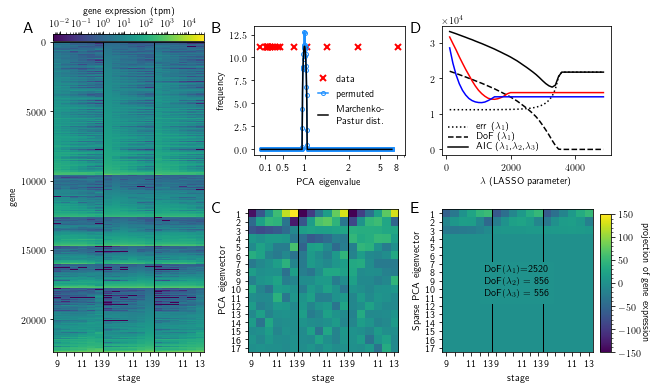

In [36]:
%matplotlib inline

fig = plt.figure(figsize=(10,6)) 

nr = 40
nc = 92
gs = gridspec.GridSpec(nr, nc)

ax1 = plt.subplot(gs[2:,0:25]) # original data
cax1 = plt.subplot(gs[1,0:25])

ax2 = plt.subplot(gs[21:,32:57]) # pca
ax4 = plt.subplot(gs[21:,64:89]) # sparse pca
cax2 = plt.subplot(gs[23:,90:92])

ax3 = plt.subplot(gs[:16,33:58]) # null distribution
ax5 = plt.subplot(gs[:16,64:]) #AIC

vircolors101 = plt.cm.viridis(np.linspace(0,1,101))

#myar = 2*nstages*nreps/ngenes
ar ='auto'
im = ax1.imshow(gdatsNZrs, aspect=ar,norm=matplotlib.colors.LogNorm())
ax1.set_xticks(np.arange(nreps*nstages))
ax1.set_xticklabels(['9','','','11','','13']*3)
ax1.set_xlabel('stage')
ax1.set_ylabel('gene')
ax1.set_yticks(np.arange(0,ngenes,5000))
ax1.vlines([nstages-0.5,nstages*2-0.5],-0.5,ngenes-0.5,color='black',linewidth=1)


# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
#divider = make_axes_locatable(ax1)
#cax     = divider.append_axes("top", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax1, orientation='horizontal', aspect=1)
cbar.set_label('gene expression (tpm)',rotation=0)
cax1.xaxis.set_label_position('top')
cax1.xaxis.set_ticks_position('top')
ticks = np.power(10.,np.arange(-3,7))
cbar.set_ticks([])

minorticks = np.array([np.arange(ticks[i],ticks[i+1],ticks[i]) for i in range(ticks.shape[0]-1)]).flatten()
mticksf    = minorticks[np.logical_and(minorticks>np.min(gdatsNZrs),minorticks<np.max(gdatsNZrs))]
ticksf     = ticks[np.logical_and(ticks>np.min(gdatsNZrs),ticks<np.max(gdatsNZrs))]

#cbar.ax.xaxis.set_ticks(minorticks, minor=True)
cax1.xaxis.set_ticks(mticksf, minor=True)
cax1.xaxis.set_ticks(ticksf)
cax1.xaxis.set_ticklabels([])

# second plot

nvecs=17
imax = 150

im1= ax2.imshow(fPCs[:,:nvecs].T, vmin=-imax, vmax=imax)
ax2.set_ylabel('PCA eigenvector')
ax2.set_xlabel('stage')
ax2.set_xticks(np.arange(0,3*nstages))
ax2.set_xticklabels(['9','','','11','','13']*3)
ax2.set_yticks(np.arange(nvecs))
ax2.set_yticklabels(np.arange(nvecs)+1)
ax2.vlines([nstages-0.5,nstages*2-0.5],-0.5,nvecs-0.5,color='black',linewidth=1)

# divider = make_axes_locatable(ax2)
# cax     = divider.append_axes("top", size="5%", pad=0.05)

cbar = fig.colorbar(im1, cax=cax2)
cbar.set_label('projection of gene expression',rotation=270, labelpad=10)
cax2.xaxis.set_label_position('top')
cax2.xaxis.set_ticks_position('top')
cax2.minorticks_on()
ax2.set_anchor('SE')

# fourth plot
im = ax4.imshow(sPCs[:,:nvecs].T, vmin=-imax, vmax=imax)
ax4.set_ylabel('Sparse PCA eigenvector')
ax4.set_xlabel('stage')
ax4.annotate('DoF$(\lambda_1)$={0}\nDoF$(\lambda_2)$ = {1}\nDoF$(\lambda_3)$ = {2}'.format(lens[0], lens[1], lens[2]), 
                xy=(1, 0), xytext=(4.5, 10),color='black', backgroundcolor=vircolors101[51])

ax4.set_xticks(np.arange(0,3*nstages))
ax4.set_xticklabels(['9','','','11','','13']*3)
ax4.vlines([5.5,11.5],-0.5,nvecs-0.5,color='black',linewidth=1)
ax4.set_yticks(np.arange(nvecs))
ax4.set_yticklabels(np.arange(nvecs)+1)
ax4.set_anchor('SE')

# third plot
ax3.plot(eigs,np.full(np.shape(eigs),1/(nrows*width)),
        **{'marker':'x','color':'red','linestyle':'','markersize':6,'markeredgewidth':2})
#Null distribution
ax3.plot(bincenters,bcs[0],**{'marker':'o','color':'dodgerblue'},markersize=4,fillstyle='none')

#MP distribution
ax3.plot(bincenters,mpdist(bincenters,nrows/ncols),color='black')

ax3.set_xscale('symlog')
ax3.set_xlabel('PCA eigenvalue',color='black')
ax3.set_ylabel('frequency',color='black')
ax3.legend(['data', 'permuted','Marchenko-\nPastur dist.'], loc=(0.4,0.2),frameon=False, handlelength=1)#,bbox_to_anchor=(0.35,0.95))
#ax.set_ylim((-0.5,16))

ax3.set_xticks([0.1,0.5,1,2,5,8])
ax3.set_xticklabels([0.1,0.5,1,2,5,8])
ax3.set_anchor('SW')


# Plot 5: AIC minimization
cols = ['k','red','blue']
ms = ['s','v','o']
fs = ['none','none','full']

const = 1/(2*sigSqPca/x.shape[1]**2)

ax5.plot(lams, const[0]*aicleft[:,0], color = cols[0], fillstyle='none', linestyle = ':', label='err ($\lambda_1$)')
ax5.plot(lams, const[0]*aicright[:,0], color = cols[0], fillstyle='none', linestyle = '--', label='DoF ($\lambda_1$)')
ax5.plot(lams, const[0]*aic[:,0], color = cols[0], fillstyle='none', label = 
         r'AIC ($\lambda_1$,'+
         r'{\color{red}$\lambda_2$},'+
         r'{\color{blue}$\lambda_3$})')
ax5.plot(lams, const[1]*aic[:,1], color = cols[1], fillstyle='none')
ax5.plot(lams, const[2]*aic[:,2], color = cols[2], fillstyle='none')
ax5.legend(loc=(0.01,-0.01), frameon=False, labelspacing=0.01)
ax5.set_xlabel('$\lambda$ (LASSO parameter)')
ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


ax1.text(-0.2, 1.03,  'A',   transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax3.text(1.05, 1.03,  'B',  transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax5.text(2.37, 1.03,  'D',  transform=ax1.transAxes, fontsize=16, fontweight='bold')

ax2.text(1.05,  0.45, 'C', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax4.text(2.37,  0.45, 'E', transform=ax1.transAxes, fontsize=16, fontweight='bold')

#plt.savefig('{0}/pca_walkthrough.eps'.format(plotdir), bbox_inches="tight")
#plt.subplots_adjust(wspace=0.3,hspace=0)
plt.show()

In [40]:
len(lams)

3